<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/SVM_MAINTANANCE_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers -q
!pip install faiss-cpu -q
!pip install sentence-transformers -q

SVM Accuracy: 0.56


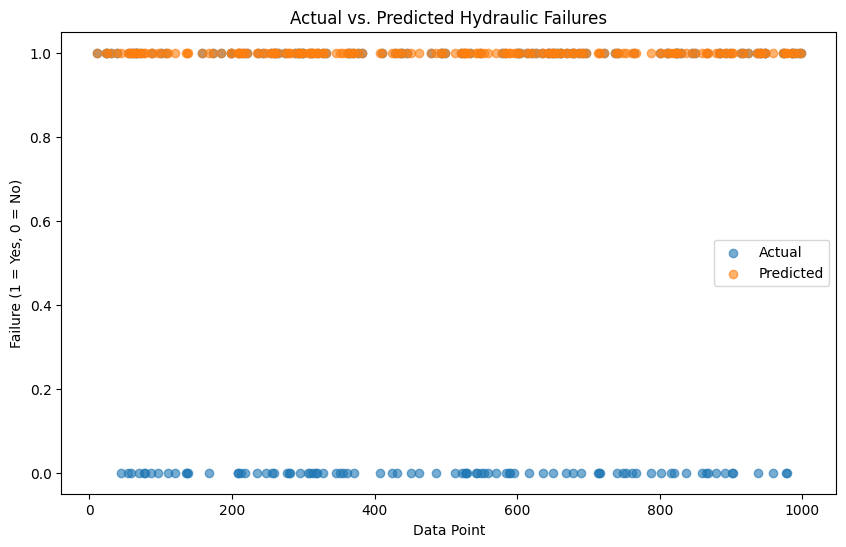

In [24]:
# Gemini 2.0: POC Full Code (Hydraulic System Focus - Complete)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModel
import faiss
import matplotlib.pyplot as plt

# --- 1. Define System and Data Parameters ---

system_name = "hydraulics"  # Focus on the hydraulic system
num_samples = 1000  # Number of synthetic data points to generate

# --- 2. Generate Synthetic Data ---

# Sensor names and ranges for the hydraulic system
sensor_names = ["pressure", "temperature", "fluid_level"]
sensor_ranges = {
    "pressure": (2500, 3000),  # Typical pressure range for 787 (psi)
    "temperature": (70, 120),  # Typical temperature range (°F)
    "fluid_level": (80, 100),  # Fluid level range (%)
}

# Generate synthetic sensor data with anomalies
sensor_data = pd.DataFrame()
for sensor in sensor_names:
    sensor_data[sensor] = np.random.uniform(
        sensor_ranges[sensor][0], sensor_ranges[sensor][1], num_samples
    )
    # Introduce anomalies for 10% of the data
    anomalous_indices = np.random.choice(num_samples, int(num_samples * 0.1), replace=False)
    if sensor == "pressure":
        sensor_data.loc[anomalous_indices, sensor] = np.random.uniform(3500, 4000, len(anomalous_indices))  # Higher pressure
    elif sensor == "temperature":
        sensor_data.loc[anomalous_indices, sensor] = np.random.uniform(150, 200, len(anomalous_indices))  # Higher temperature
    elif sensor == "fluid_level":
        sensor_data.loc[anomalous_indices, sensor] = np.random.uniform(40, 60, len(anomalous_indices))  # Lower fluid level

# Generate synthetic maintenance logs with stronger failure correlation
def generate_log_entry(failure):
    if failure:
        templates = [
            "Hydraulic leak detected and repaired. Significant fluid loss.",
            "Hydraulic pump replaced due to catastrophic failure.",
            "Abnormal noise from hydraulic pump, replaced due to damage.",
            "Hydraulic system pressure unstable, major component replaced.",
            "Extremely low fluid level detected, major leak repaired.",
        ]
    else:
        templates = [
            "Routine inspection of hydraulic system completed. No issues found.",
            "Minor leak detected in hydraulic system. Repaired and topped off fluid.",
            "Hydraulic pump replaced due to wear and tear.",
            "Abnormal noise from hydraulic pump. Investigated, no issue found.",
            "Hydraulic system pressure fluctuating. Adjusted pressure relief valve.",
        ]
    return np.random.choice(templates)

maintenance_logs = pd.DataFrame(
    {
        "log_text": [generate_log_entry(failure) for failure in np.random.randint(0, 2, num_samples)],
        "failure": np.random.randint(0, 2, num_samples),  # Binary failure indicator
    }
)

# --- 3. Load Knowledge Base and Create FAISS Index ---

# Expanded knowledge base
knowledge_base = [
    {
        "title": "787 Hydraulic System Overview",
        "content": "The Boeing 787 hydraulic system is comprised of three independent hydraulic systems that provide power for flight controls, landing gear, brakes, and other systems. Each system uses Skydrol-resistant components and operates at 3,000 psi. The system includes engine-driven pumps, electric pumps, reservoirs, accumulators, and various valves and actuators.",
    },
    {
        "title": "Troubleshooting Hydraulic Leaks",
        "content": "Common causes of hydraulic leaks in the 787 include worn seals, damaged hoses, loose fittings, and component failures. Troubleshooting steps include visual inspection, pressure testing, and fluid analysis.",
    },
    {
        "title": "787 Hydraulic Pumps",
        "content": "The 787 uses two types of hydraulic pumps: engine-driven pumps (EDPs) and electric pumps. The EDPs are powered by the aircraft's engines and provide high-pressure hydraulic power for primary flight controls. The electric pumps are used for backup and auxiliary functions. The EDPs typically operate at 3,000 psi and have a flow rate of ... gallons per minute. Common failure modes for EDPs include seal wear, bearing failure, and cavitation.",
    },
    {
        "title": "Hydraulic Actuators",
        "content": "Hydraulic actuators convert hydraulic pressure into mechanical force to move flight control surfaces, landing gear, and other components. The 787 uses both linear and rotary actuators. Linear actuators provide straight-line motion, while rotary actuators produce rotational motion. Common actuator issues include leaks, slow response, and jamming.",
    },
    {
        "title": "Hydraulic Fluid",
        "content": "The 787 hydraulic system uses Skydrol-type hydraulic fluid, which is phosphate ester-based. Skydrol is fire-resistant and has a wide operating temperature range. It is important to use the correct type of Skydrol and to avoid contamination with other fluids.",
    },
    {
        "title": "Hydraulic System Maintenance",
        "content": "Routine maintenance for the 787 hydraulic system includes visual inspections for leaks, checking fluid levels and condition, and operational tests of components. More extensive maintenance may involve replacing seals, hoses, or pumps.",
    },
    {
        "title": "Hydraulic System Safety",
        "content": "Always depressurize the hydraulic system before performing maintenance. Use caution when working with hydraulic fluid, as it can be harmful to skin and eyes. Wear appropriate protective equipment.",
    },
]


# Initialize tokenizer and model (using bert-large-uncased)
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")
model = AutoModel.from_pretrained("bert-large-uncased")


# Generate embeddings for knowledge base documents
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :].detach().numpy()
    return embeddings

embeddings = []
for document in knowledge_base:
    embeddings.append(get_bert_embeddings(document["content"]))
embeddings = np.array(embeddings).squeeze()

# Create FAISS index
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

# --- 4. Generate Embeddings and Combine Features ---

# Generate bert-base-uncased embeddings for maintenance logs
maintenance_logs["embeddings"] = maintenance_logs["log_text"].apply(
    get_bert_embeddings
)

# Combine features (embeddings and sensor data) - with feature scaling and interaction terms
features = pd.DataFrame(np.vstack(maintenance_logs["embeddings"]))
features["pressure_x_temp"] = sensor_data["pressure"] * sensor_data["temperature"]
features["pressure_div_fluid"] = sensor_data["pressure"] / sensor_data["fluid_level"]
features = pd.concat([features, sensor_data], axis=1)

# Scale only the sensor data columns
scaler = StandardScaler()
sensor_data_scaled = scaler.fit_transform(sensor_data)  # Scale sensor data separately
features[sensor_names] = sensor_data_scaled  # Update sensor columns in features

features.columns = features.columns.astype(str)  # Ensure column names are strings


# --- 5. Train SVM Model ---

X_train, X_test, y_train, y_test = train_test_split(
    features, maintenance_logs["failure"], test_size=0.2, random_state=42
)

# Use grid search to find optimal hyperparameters
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 'scale']}
svm_model = GridSearchCV(SVC(kernel="rbf"), param_grid, refit=True)
svm_model.fit(X_train, y_train)

# --- 6. Evaluate Model ---

y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy}")

# --- 7. Visualize Results ---

# Visualize the predicted vs. actual failures
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, label="Actual", alpha=0.6)
plt.scatter(X_test.index, y_pred, label="Predicted", alpha=0.6)
plt.xlabel("Data Point")
plt.ylabel("Failure (1 = Yes, 0 = No)")
plt.title("Actual vs. Predicted Hydraulic Failures")
plt.legend()
plt.show()

In [28]:
# ... (other code remains the same) ...

# --- 8. AOG Scenario ---

# Simulate AOG data
aog_sensor_data = pd.DataFrame({
    "pressure": [2800],  # Slightly lower pressure
    "temperature": [100],  # Normal temperature
    "fluid_level": [78],  # Slightly low fluid level
})
aog_log_text = "Slight drop in hydraulic fluid level noticed during post-flight inspection."

# Generate embedding for AOG log entry
aog_embedding = get_bert_embeddings(aog_log_text)

# Combine features for AOG scenario
aog_features = pd.DataFrame(aog_embedding)
# Convert column names to strings and ensure they match the training data
num_embedding_cols = aog_embedding.shape[1]
embedding_col_names = [str(i) for i in range(num_embedding_cols)]
aog_features.columns = embedding_col_names

# Calculate interaction terms and add them to aog_features
aog_features["pressure_x_temp"] = aog_sensor_data["pressure"] * aog_sensor_data["temperature"]
aog_features["pressure_div_fluid"] = aog_sensor_data["pressure"] / aog_sensor_data["fluid_level"]
aog_features = pd.concat([aog_features, aog_sensor_data], axis=1)

# Reorder columns to match the order in X_train
aog_features = aog_features[X_train.columns] # Ensure column order is consistent

# Scale the AOG features using only the sensor data columns
# Select the sensor data columns
aog_sensor_data_to_scale = aog_features[sensor_names]

# Scale the selected columns
scaled_aog_sensor_data = scaler.transform(aog_sensor_data_to_scale)

# Update the sensor data columns in aog_features with the scaled values
aog_features[sensor_names] = scaled_aog_sensor_data

# Make prediction for AOG scenario
aog_prediction = svm_model.predict(aog_features)

# Interpret the prediction and provide refined recommendation
if aog_prediction[0] == 1:
    print("AOG Prediction: Potential hydraulic failure detected.")
    print("Recommended Action: Ground the aircraft for immediate inspection and maintenance. Do not dispatch the aircraft until the issue is resolved and the hydraulic system is deemed fully operational. Safety is our top priority. A potential hydraulic failure poses a significant risk, and it's crucial to take proactive measures to prevent any potential incidents.")
else:
    print("AOG Prediction: No immediate hydraulic failure predicted.")
    print("Recommended Action: Proceed with the scheduled flight. However, continue to monitor the hydraulic system closely during the flight and conduct a thorough inspection at the next scheduled maintenance check. While the system is not predicted to fail imminently, it's important to remain vigilant and ensure the hydraulic system's ongoing integrity.")

AOG Prediction: Potential hydraulic failure detected.
Recommended Action: Ground the aircraft for immediate inspection and maintenance. Do not dispatch the aircraft until the issue is resolved and the hydraulic system is deemed fully operational. Safety is our top priority. A potential hydraulic failure poses a significant risk, and it's crucial to take proactive measures to prevent any potential incidents.
